# Analyse de la qualité de l'air à Grenoble

Ce document présente une tentative d'analyse de l'évolution de la qualité de l'air à Grenoble suite au confinement du 17 mars 2020.

Les analyses ci-dessous ont été réalisées avec le langage de programmation R et les bibliothèques suivantes :

In [1]:
library(dplyr)
library(tidyr)
library(ggplot2)
library(patchwork)
library(lubridate)
library(zoo)
library(repr)
options(repr.plot.width=16, repr.plot.height=8)
R.version.string


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘lubridate’

The following object is masked from ‘package:base’:

    date


Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric



[1] "R version 3.5.2 (2018-12-20)"

## Récupération et nettoyage des données

Toutes les données ont été récupérées sur le site d'[Atmo](https://www.atmo-auvergnerhonealpes.fr/donnees/telecharger) en remplissant le formulaire. Les différents fichiers ainsi téléchargés se trouvent dans le dossier [data](data).

Le format de données est particulièrement pénible, une colonne par date. On va d'abord restructurer ça pour avoir une observation par ligne. On convertit également les colonnes `Date` et `Valeur` dans les types adéquats.

In [2]:
filenames = c(
    'data/2017_hourly.csv',
    'data/2018_hourly.csv',
    'data/2019_hourly.csv',
    'data/2020_hourly.csv'
)
df = data.frame()
for(file in filenames) {
    new_df = read.csv(file, sep=';') %>%
        mutate_all(as.character) %>%
        pivot_longer(c(-Station, -Polluant, -Mesure, -Unité), names_to="raw_date", values_to="Valeur", names_prefix="X") %>%
        mutate(Date=parse_date_time(raw_date, "dmyhM"), Valeur=as.numeric(sub(",", ".", Valeur)))
    df = rbind(df, new_df)
}
str(df)
head(df)

Warning message:
“ 18 failed to parse.”Warning message:
“NAs introduits lors de la conversion automatique”Warning message:
“ 18 failed to parse.”Warning message:
“NAs introduits lors de la conversion automatique”Warning message:
“ 17 failed to parse.”Warning message:
“NAs introduits lors de la conversion automatique”Warning message:
“NAs introduits lors de la conversion automatique”

Classes ‘tbl_df’, ‘tbl’ and 'data.frame':	509621 obs. of  7 variables:
 $ Station : chr  "Grenoble Rocade Sud" "Grenoble Rocade Sud" "Grenoble Rocade Sud" "Grenoble Rocade Sud" ...
 $ Polluant: chr  "Dioxyde d'azote" "Dioxyde d'azote" "Dioxyde d'azote" "Dioxyde d'azote" ...
 $ Mesure  : chr  "Dioxyde d'azote" "Dioxyde d'azote" "Dioxyde d'azote" "Dioxyde d'azote" ...
 $ Unité   : chr  "microg/m3" "microg/m3" "microg/m3" "microg/m3" ...
 $ raw_date: chr  "01.01.2017.0.00" "01.01.2017.1.00" "01.01.2017.2.00" "01.01.2017.3.00" ...
 $ Valeur  : num  55 45 46 47 44 46 41 41 43 40 ...
 $ Date    : POSIXct, format: "2017-01-01 00:00:00" "2017-01-01 01:00:00" ...


Station,Polluant,Mesure,Unité,raw_date,Valeur,Date
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dttm>
Grenoble Rocade Sud,Dioxyde d'azote,Dioxyde d'azote,microg/m3,01.01.2017.0.00,55,2017-01-01 00:00:00
Grenoble Rocade Sud,Dioxyde d'azote,Dioxyde d'azote,microg/m3,01.01.2017.1.00,45,2017-01-01 01:00:00
Grenoble Rocade Sud,Dioxyde d'azote,Dioxyde d'azote,microg/m3,01.01.2017.2.00,46,2017-01-01 02:00:00
Grenoble Rocade Sud,Dioxyde d'azote,Dioxyde d'azote,microg/m3,01.01.2017.3.00,47,2017-01-01 03:00:00
Grenoble Rocade Sud,Dioxyde d'azote,Dioxyde d'azote,microg/m3,01.01.2017.4.00,44,2017-01-01 04:00:00
Grenoble Rocade Sud,Dioxyde d'azote,Dioxyde d'azote,microg/m3,01.01.2017.5.00,46,2017-01-01 05:00:00


In [3]:
df %>% group_by(Mesure) %>% count()

Mesure,n
<chr>,<int>
Dioxyde d'azote,115788
Dioxyde de soufre,28947
Monoxyde d'azote,115788
Ozone,57894
Particules PM10,115788
"Particules PM2,5",17522
Particules PM2.5,57894


On voit qu'il y a deux intitulés différents pour les PM 2.5, l'un avec une virgule, l'autre avec un point. On renomme celui avec la virgule.

In [4]:
df = df %>% mutate(Mesure=ifelse(grepl("Particules PM2", Mesure), "Particules PM2.5", Mesure))
df %>% group_by(Mesure) %>% count()

Mesure,n
<chr>,<int>
Dioxyde d'azote,115788
Dioxyde de soufre,28947
Monoxyde d'azote,115788
Ozone,57894
Particules PM10,115788
Particules PM2.5,75416


Un certain nombre de valeurs sont manquantes. On commence par regarder si elles ont une distribution particulière.

In [5]:
df %>% filter(is.na(Date)) %>% select(raw_date, Date) %>% unique()

raw_date,Date
<chr>,<dttm>
29.10.2017.2.00.1,NA
28.10.2018.2.00.1,NA
27.10.2019.2.00.1,NA


In [6]:
df %>% filter(grepl("29.10.2017.2.00|28.10.2018.2.00|27.10.2019.2.00", raw_date)) %>% select(raw_date, Date) %>% unique()

raw_date,Date
<chr>,<dttm>
29.10.2017.2.00,2017-10-29 02:00:00
29.10.2017.2.00.1,NA
28.10.2018.2.00,2018-10-28 02:00:00
28.10.2018.2.00.1,NA
27.10.2019.2.00,2019-10-27 02:00:00
27.10.2019.2.00.1,NA


Il y a deux entrées pour une même date les 29 octobre 2017, 28 octobre 2018 et 27 octobre 2019, à 02:00 du matin. Il s'agit des dates de passage à l'heure d'hiver, on va simplement supprimer les doublons.

In [7]:
df = df %>% filter(!is.na(Date))

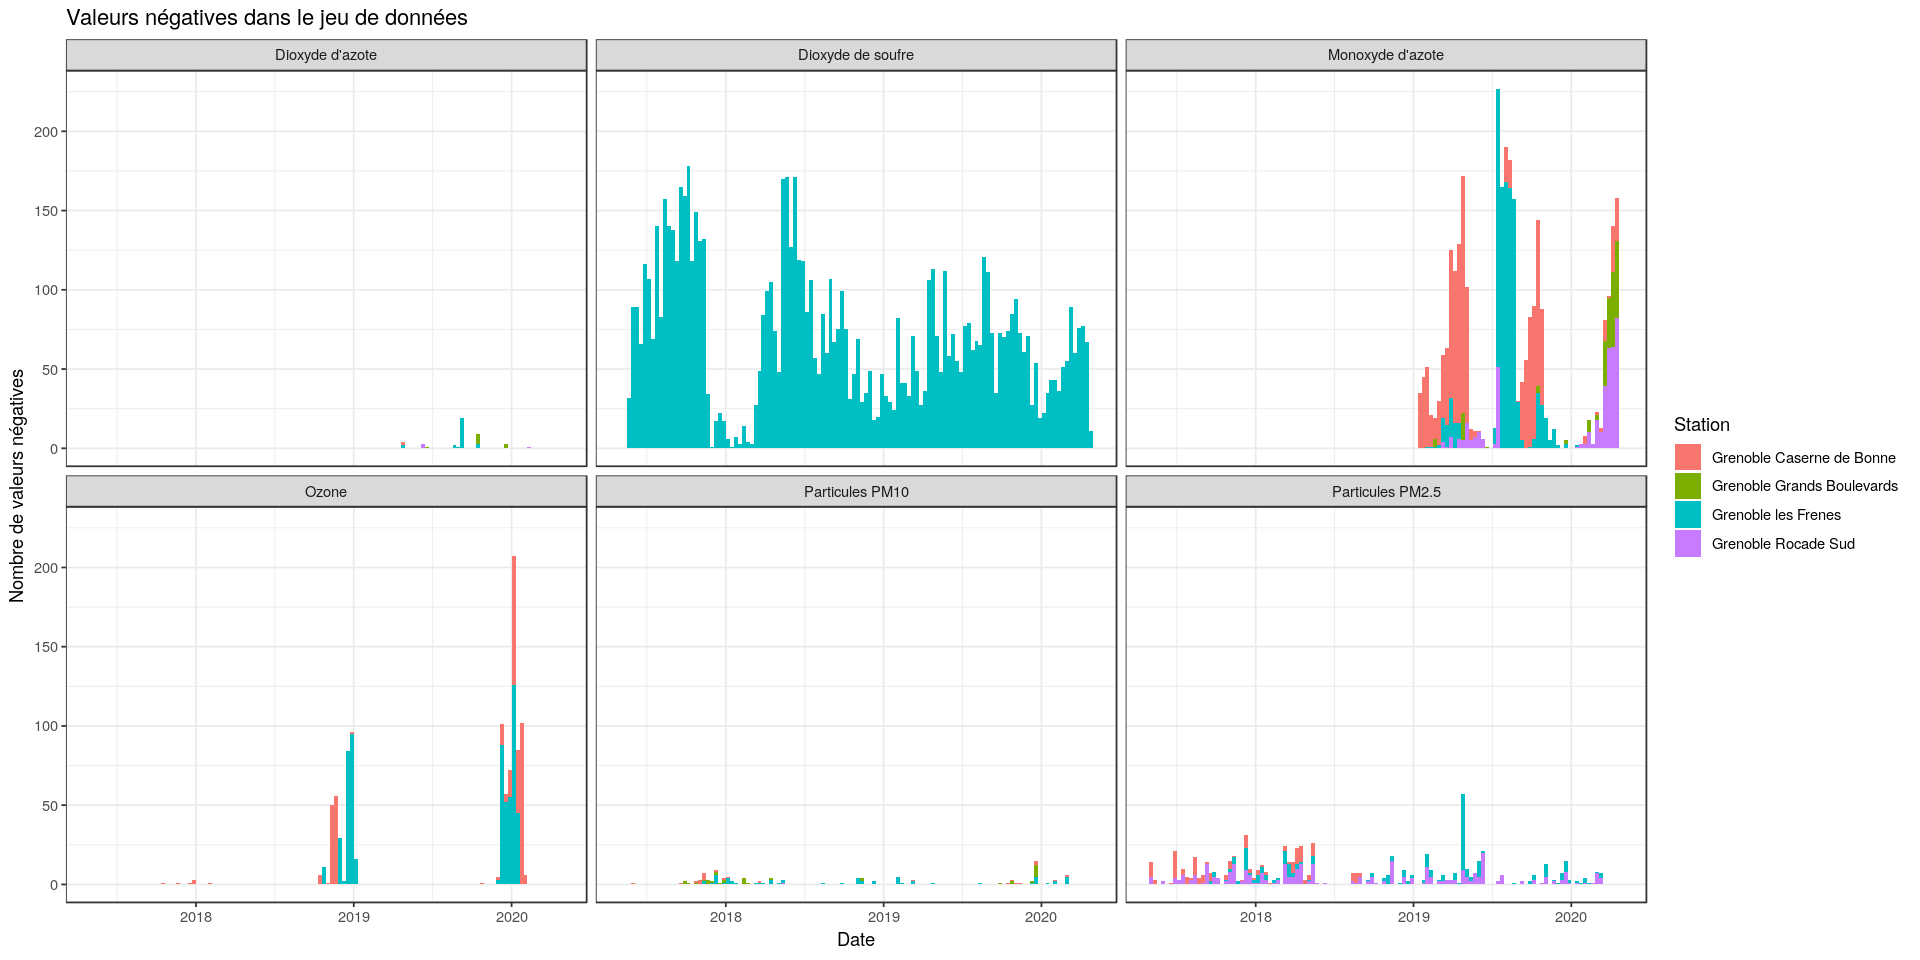

In [8]:
nb_days = as.numeric(max(df$Date) - min(df$Date))
df %>%
    filter(Valeur < 0) %>%
    ggplot() +
    aes(x=Date, fill=Station) +
    facet_wrap("Mesure") +
    geom_histogram(bins=nb_days/10) +
    theme_bw() +
    ylab("Nombre de valeurs négatives") +
    ggtitle("Valeurs négatives dans le jeu de données")

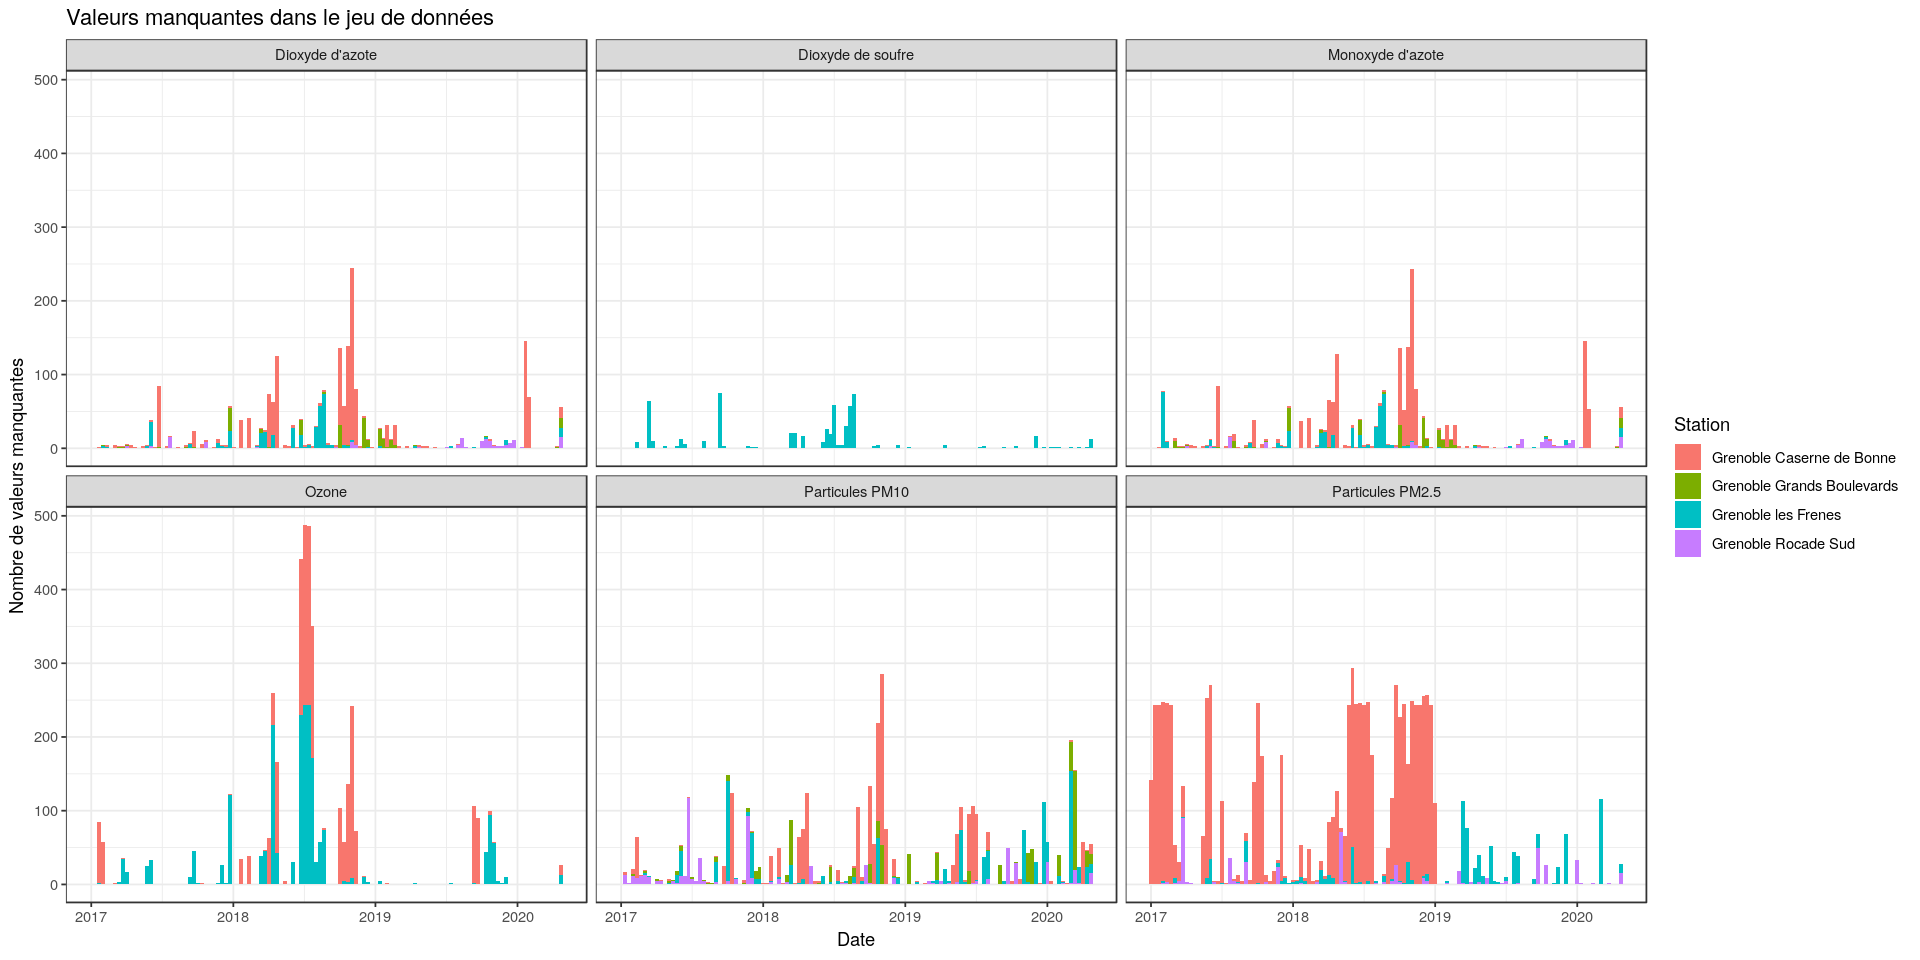

In [9]:
nb_days = as.numeric(max(df$Date) - min(df$Date))
df %>%
    filter(is.na(Valeur)) %>%
    ggplot() +
    aes(x=Date, fill=Station) +
    facet_wrap("Mesure") +
    geom_histogram(bins=nb_days/10) +
    theme_bw() +
    ylab("Nombre de valeurs manquantes") +
    ggtitle("Valeurs manquantes dans le jeu de données")

On peut constater des manques de données sur certaines periodes, pour certaines stations. Cela correspond probablement à des pannes des capteurs. Ça sera à garder en tête par la suite dans les interprétations des courbes. On supprime les entrées avec des données manquantes.

In [10]:
df = df %>% drop_na()

Une première courbe d'évolution, pour visualiser les patterns temporels.

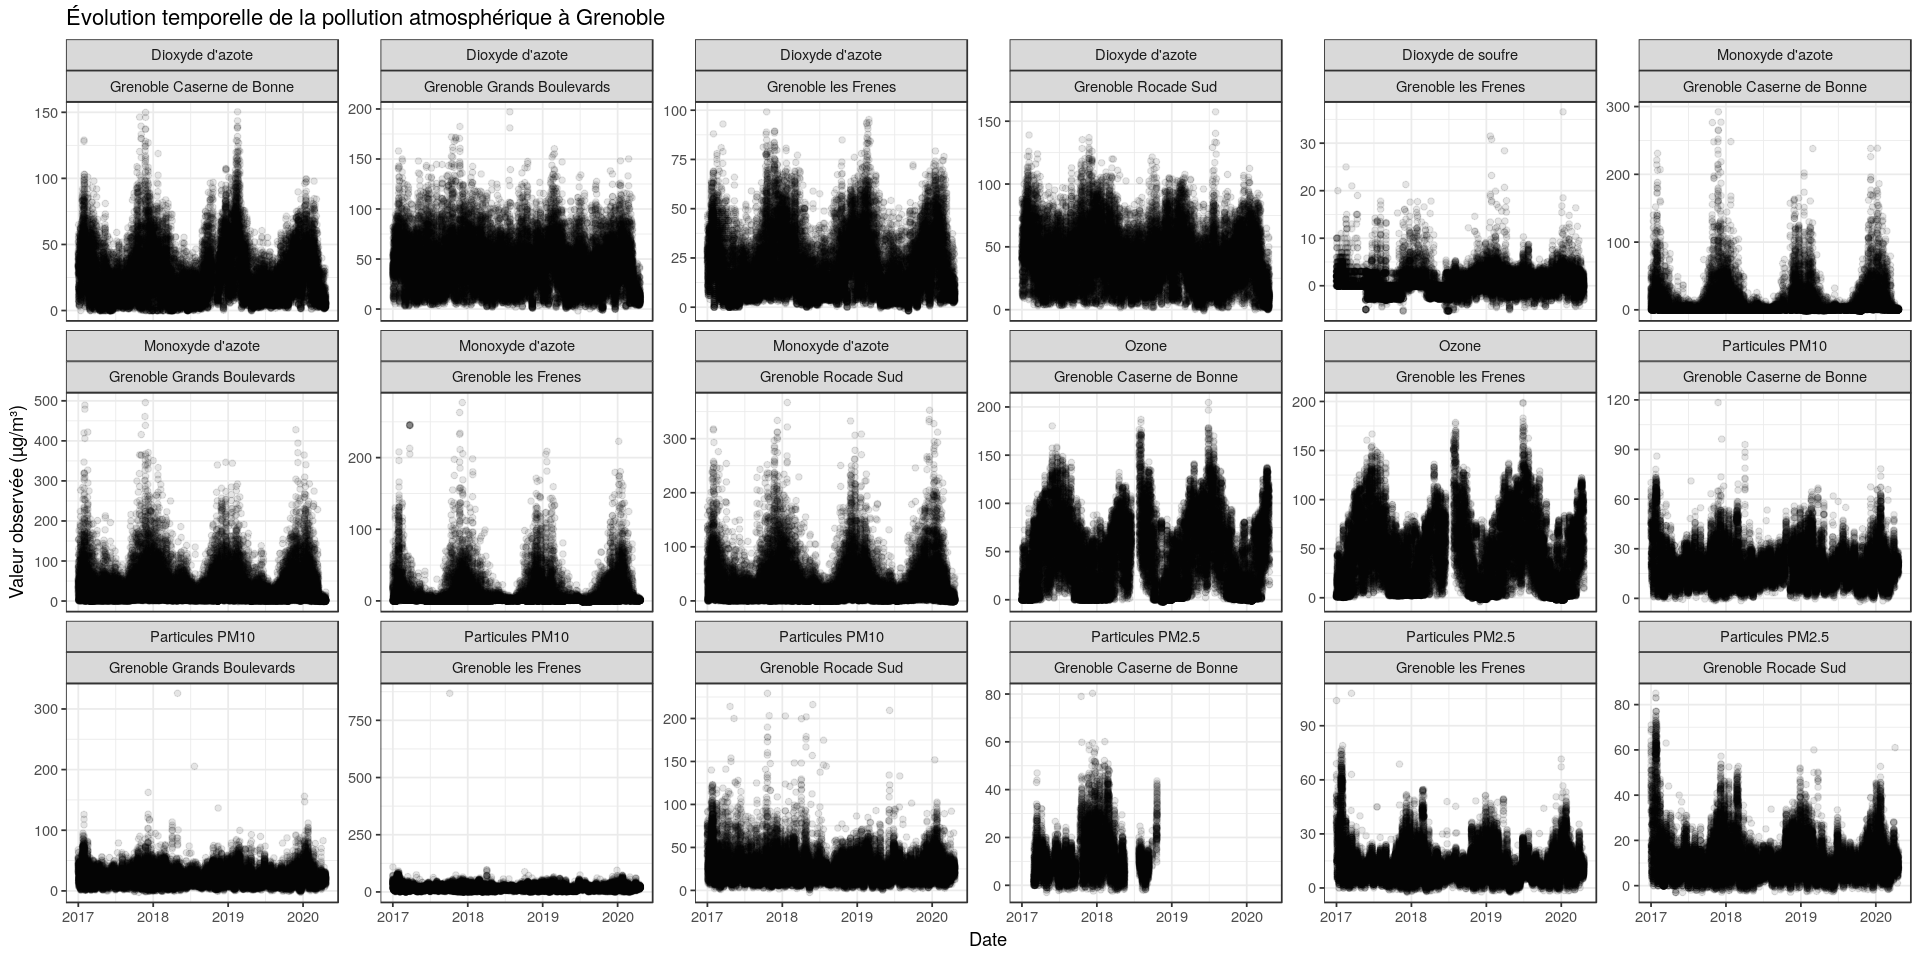

In [11]:
df %>% ggplot() +
    aes(x=Date, y=Valeur) +
    facet_wrap(c("Mesure", "Station"), scales='free_y', nrow=3) +
    geom_point(alpha=0.1) +
    theme_bw() +
    expand_limits(y=0) +
    ylab("Valeur observée (µg/m³)") +
    ggtitle("Évolution temporelle de la pollution atmosphérique à Grenoble")

La station *Grenoble Caserne de Bonne* avait déjà plusieurs pannes pour le capteur PM2.5, on voit sur cette dernière courbe qu'il n'y a carrément plus rien à partir de fin 2018. On va donc supprimer toutes les mesures PM2.5 de cette station.

De même, on supprime l'unique capteur de dioxyde de soufre, qui renvoie de nombreuses valeurs négatives.

In [12]:
df = df %>% filter((Station != "Grenoble Caserne de Bonne") | (Mesure != "Particules PM2.5"))
df = df %>% filter(Mesure != "Dioxyde de soufre")

Enfin, on ajoute diverses variables, comme l'année, le jour, le numéro de jour (entre 1 et 366), le numéro de semaine (entre 1 et 53).

In [13]:
df = df %>% mutate(Annee=year(Date), Mois=month(Date), Jour=day(Date), NumeroJour=yday(Date), NumeroSemaine=week(Date), Instant=parse_date_time(format(Date, format="%m/%d %H:%M"), "mdhM"))

## Analyse des données

Il y a beaucoup de variabilité dans les données, il est difficile de voir quelque chose. Pour "lisser" tout ça, on prend une moyenne roulante sur 7 jours.

In [14]:
width = 24*7
df = df %>%
    group_by(Station, Mesure) %>%
    mutate(avg=rollapply(Valeur, width, mean, fill=NA), se=rollapply(Valeur, width, sd, fill=NA)) %>%
    drop_na() %>%
    ungroup()

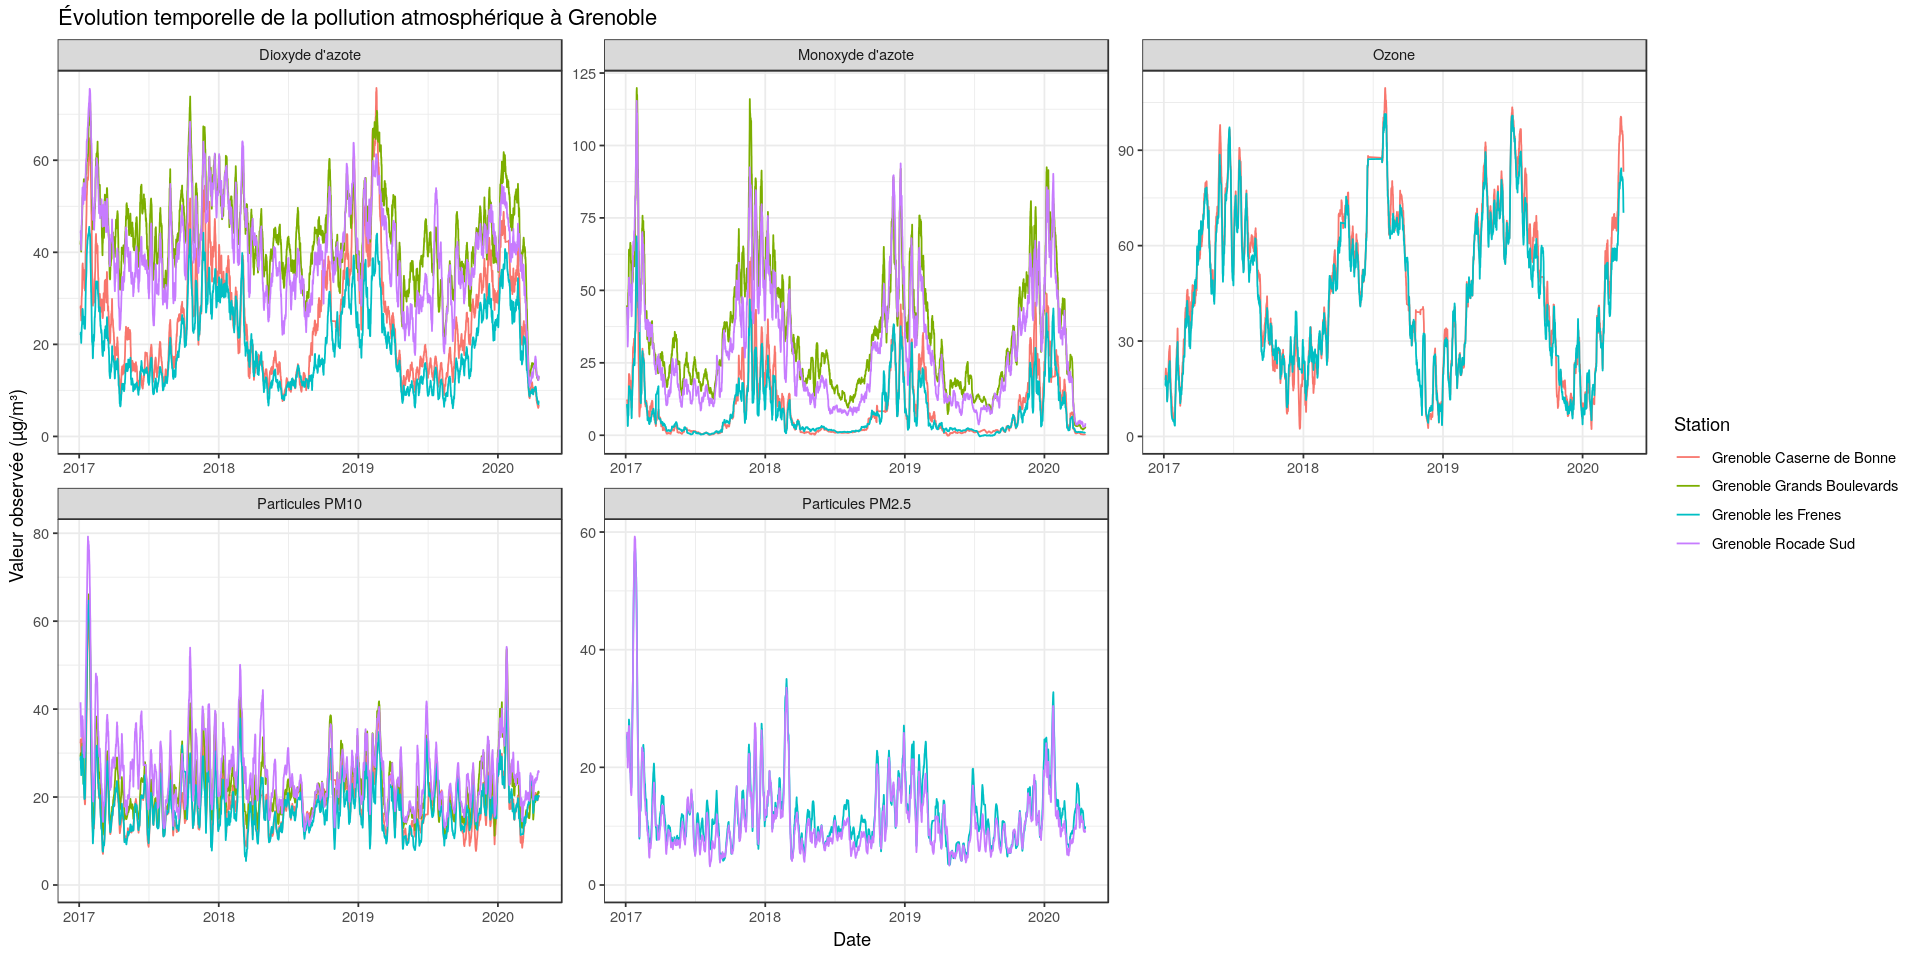

In [15]:
df %>%
    ggplot() +
    aes(x=Date, y=avg, color=Station) +
    facet_wrap(c("Mesure"), scales='free') +
    geom_line() +
    theme_bw() +
    expand_limits(y=0) +
    ylab("Valeur observée (µg/m³)") +
    ggtitle("Évolution temporelle de la pollution atmosphérique à Grenoble")

On va maintenant regarder si le confinement (qui a débuté officiellement le 17 mars 2020 à 12h) à un quelconque effet.

In [16]:
df = df %>%
    mutate(Confinement = Date >= parse_date_time("17/03/2020 12:00", "dmyhM"))

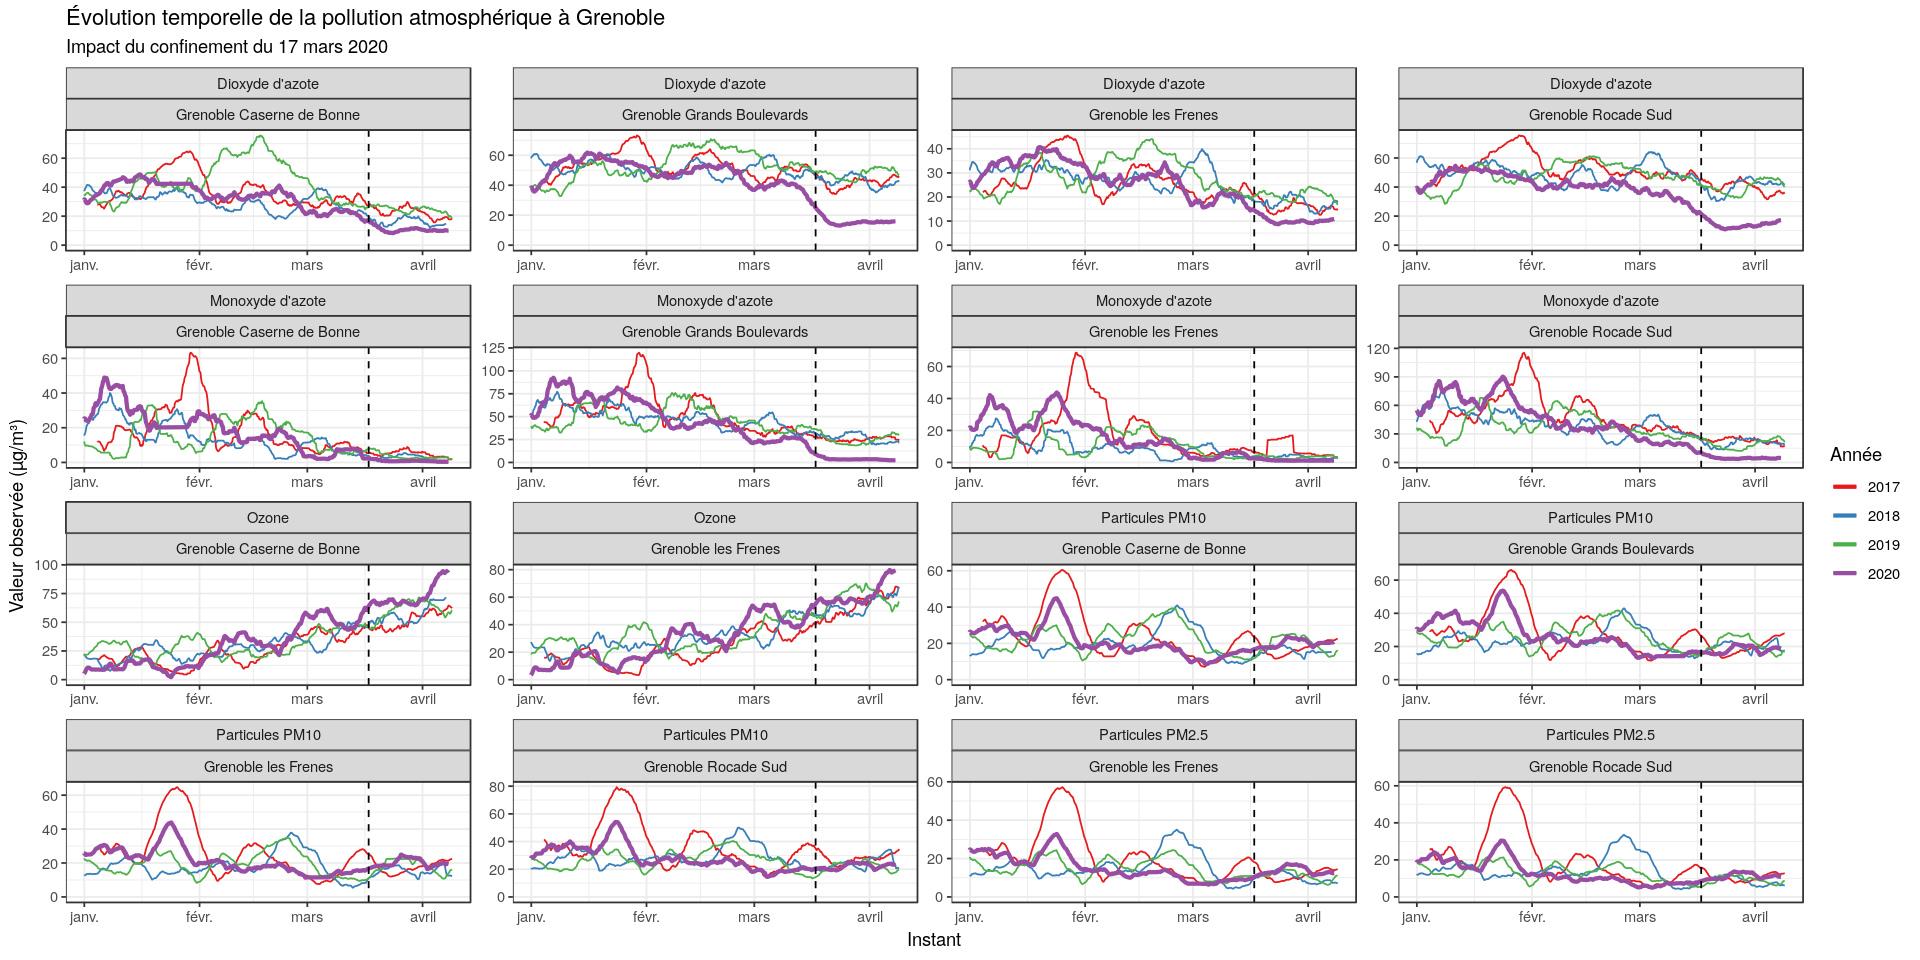

In [17]:
df %>%
    filter(NumeroSemaine < 15) %>% {
    ggplot(.) +
    aes(x=Instant, y=avg, color=factor(Annee)) +
    facet_wrap(c("Mesure", "Station"), scales='free') +
    geom_line() +
    geom_line(data=filter(., Annee == 2020), size=1.2) +
    theme_bw() +
    expand_limits(y=0) +
    scale_colour_brewer(palette = "Set1") +
    geom_vline(xintercept=parse_date_time("17/03 12:00", "dmhM"), linetype='dashed') +
    ylab("Valeur observée (µg/m³)") +
    labs(color='Année') +
    ggtitle("Évolution temporelle de la pollution atmosphérique à Grenoble") +
    labs(subtitle="Impact du confinement du 17 mars 2020")
}

Visuellement, le confinement (représenté par la ligne verticale en pointillés) semble avoir réduit les concentrations de dioxyde d'azote et de monoxyde d'azote. Il ne semble pas y avoir d'effet sur les concentrations d'ozone et de particules fines (PM10 et PM2.5). On va maintenant calculer le pourcentage de diminution (ou augmentation) entre 2020 et la moyenne des trois autres années, pour chacune des 14 premières semaines.

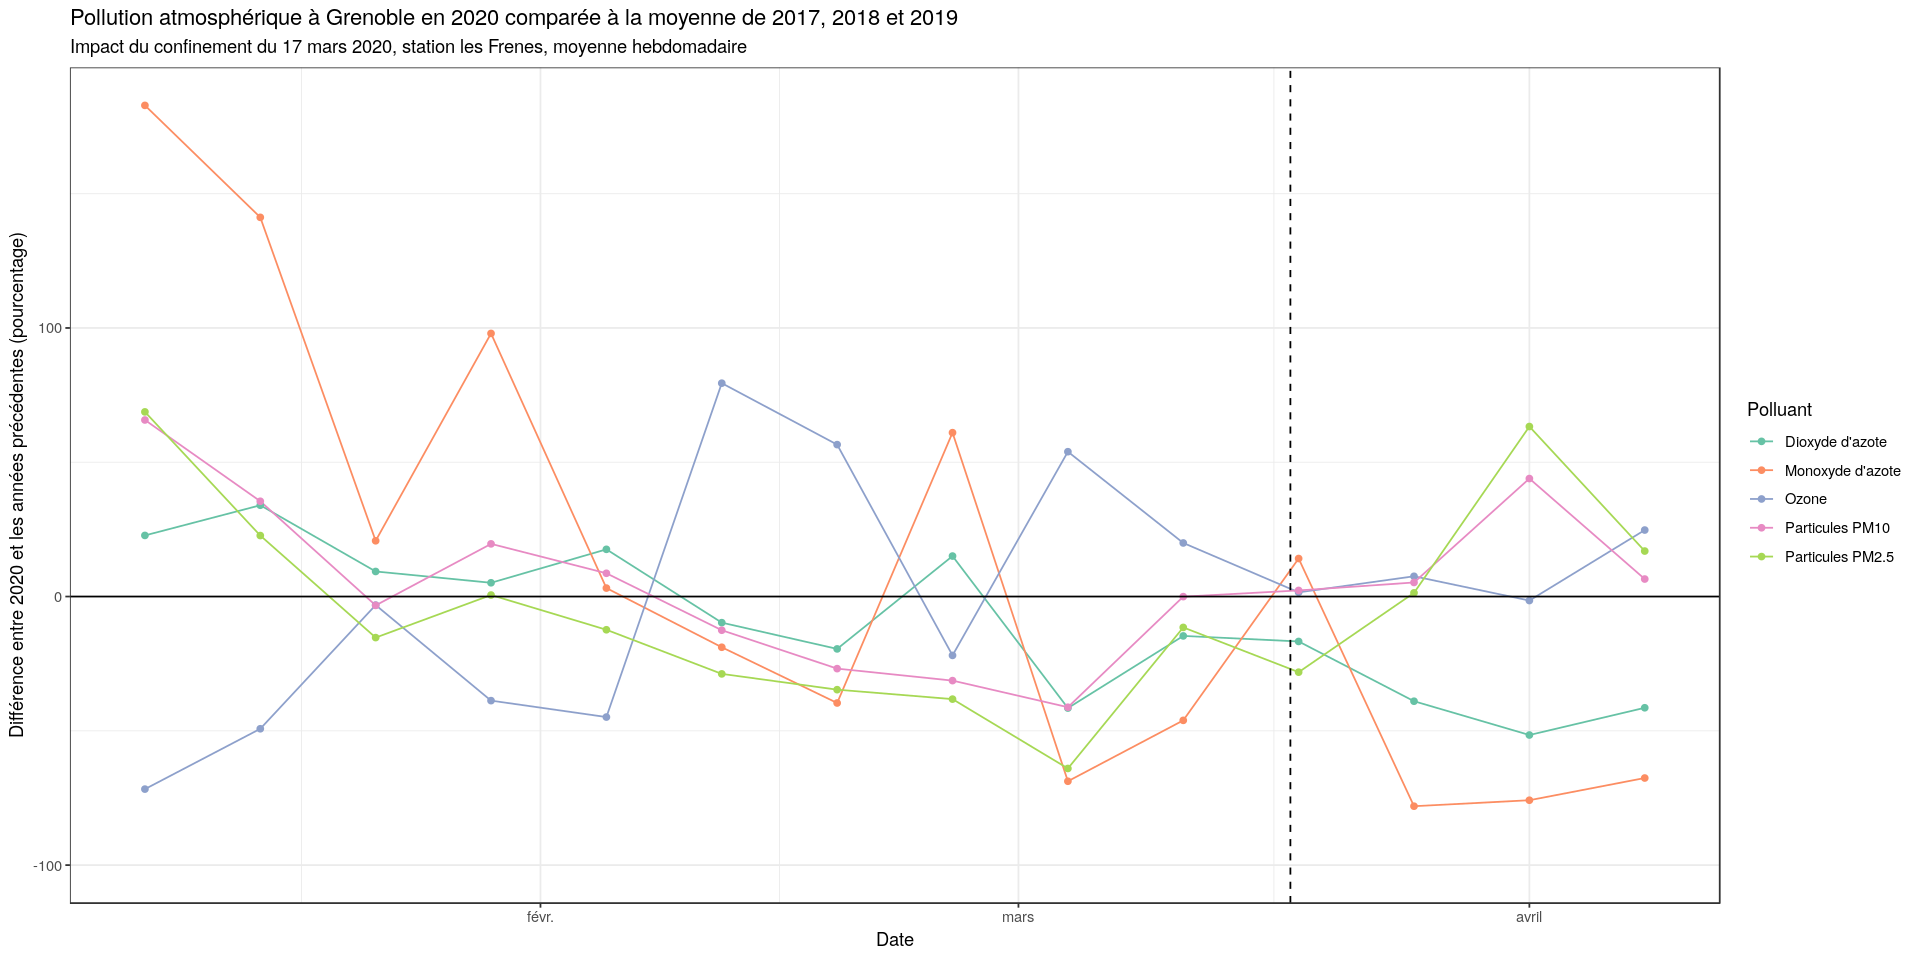

In [18]:
df_old = df %>% filter(Station == "Grenoble les Frenes", Annee <= 2019, NumeroSemaine < 15) %>% group_by(Mesure, NumeroSemaine) %>% summarise(avg=mean(Valeur))
df_new = df %>% filter(Station == "Grenoble les Frenes", Annee == 2020, NumeroSemaine < 15) %>% group_by(Mesure, NumeroSemaine) %>% summarise(avg=mean(Valeur))
df_old %>%
    full_join(df_new, by=c("Mesure", "NumeroSemaine"), suffix=c("_old", "_new")) %>%
    mutate(ratio = (avg_new-avg_old)/avg_old*100) %>%
    ungroup() %>%
    mutate(Date=parse_date_time("01-01", "md") + lubridate::weeks(NumeroSemaine)) %>%
    ggplot() +
    aes(x=Date, y=ratio, color=Mesure) +
    geom_line() +
    geom_point() +
    geom_vline(xintercept=parse_date_time("17/03 12:00", "dmhM"), linetype='dashed') +
    geom_hline(yintercept = 0) +
    theme_bw() +
    scale_colour_brewer(palette = "Set2") +
    expand_limits(y=c(-100, +100)) +
    labs(color="Polluant") +
    ylab("Différence entre 2020 et les années précédentes (pourcentage)") +
    ggtitle("Pollution atmosphérique à Grenoble en 2020 comparée à la moyenne de 2017, 2018 et 2019") +
    labs(subtitle="Impact du confinement du 17 mars 2020, station les Frenes, moyenne hebdomadaire")

## Conclusion

- Pas de différence importante concernant les particules fines (PM10 ou PM2.5) et l'ozone.
- Une chute notable du dioxyde d'azote et du monoxyde d'azote (respectivement environ -50% et -70%).

Il est surprenant que l'ozone ne chute pas également. En effet, d'après [Wikipedia](https://fr.wikipedia.org/wiki/Ozone_troposph%C3%A9rique#Origine), dans la troposphère il est produit principalement à partir de monoxyde d'azote, lui même produit à partir de dioxyde d'azote. Peut-être y a-t-il une forme d'inertie et va-t-il lui aussi se mettre à chuter dans les semaines à venir ?